In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import json
import shutil
import cv2
import tensorflow as tf
import tensorflow.keras as keras

from PIL import Image
from glob import glob
from tensorflow.keras import applications
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import losses
from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing import image

In [3]:
BASE_PATH = os.path.join("\\".join(dirc for dirc in os.getcwd().split("\\")[:-1]), "data")
BASE_PATH

'C:\\Users\\Scooby Doo\\Projects\\malaria_detection\\data'

In [4]:
dirnames = sorted([dirname for dirname in os.listdir(BASE_PATH)])
records = [(os.path.join(BASE_PATH, dirname, filename), dirname) for dirname in dirnames for filename in os.listdir(os.path.join(BASE_PATH, dirname)) if filename.endswith('.png')]

df = pd.DataFrame(records, columns=["image", "category"])
df.head()

,image,category
0,C:\Users\Scooby Doo\Projects\malaria_detection...,Parasitized
1,C:\Users\Scooby Doo\Projects\malaria_detection...,Parasitized
2,C:\Users\Scooby Doo\Projects\malaria_detection...,Parasitized
3,C:\Users\Scooby Doo\Projects\malaria_detection...,Parasitized
4,C:\Users\Scooby Doo\Projects\malaria_detection...,Parasitized


In [5]:
df.image[0]

'C:\\Users\\Scooby Doo\\Projects\\malaria_detection\\data\\Parasitized\\C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [6]:
# Now check class balance
df.category.value_counts()

Parasitized    13779
Uninfected     13779
Name: category, dtype: int64

In [7]:
os.mkdir(os.path.join(BASE_PATH, "train"))
os.mkdir(os.path.join(BASE_PATH, "valid"))

In [15]:
categories = list(df.category.unique())
categories

['Parasitized', 'Uninfected']

In [19]:
for category in categories:
    category_train = glob(os.path.join(BASE_PATH, category, "*.png"))
    shuf = np.random.permutation(category_train)

    os.mkdir(os.path.join(BASE_PATH, "train", category))
    for i in range(len(category_train)): shutil.copy2(shuf[i], os.path.join(BASE_PATH, "train", category))

In [20]:
len(os.listdir(os.path.join(BASE_PATH, "train", "Parasitized")))

13779

In [21]:
len(os.listdir(os.path.join(BASE_PATH, "train", "Uninfected")))

13779

In [23]:
# Lets create validation data from train data
for dirpath in dirpaths:
    category = dirpath.split("/")[-1]
    category_valid = glob(os.path.join(BASE_PATH, "train", category, "*.png"))
    shuf = np.random.permutation(category_valid)
    
    print(category, len(category_valid))
    os.mkdir(os.path.join(BASE_PATH, "valid", category))
    for i in range(int(len(category_valid) / 4)): shutil.move(shuf[i], os.path.join(BASE_PATH, "valid", category))

Parasitized 13779
Uninfected 13779


In [24]:
len(os.listdir(os.path.join(BASE_PATH, "valid", "Parasitized")))

3444

In [25]:
len(os.listdir(os.path.join(BASE_PATH, "valid", "Uninfected")))

3444

In [29]:
def display_images(path, color_channel=3, width=100, height=100, number_images=5):
    image_names = os.listdir(path)
    random.shuffle(image_names)
    image_array = np.empty((number_images, width, height, color_channel))
    
    plt.clf()
    fig, axs = plt.subplots(1, number_images, figsize=(25, number_images))
    
    for i, ax, record in zip(range(number_images), axs, image_names[:number_images]):
        img = cv2.imread(os.path.join(path, record))
        img = cv2.resize(img, (width, height))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image_array[i] = img
        
        ax.set_title(path.split("\\")[-1])
        ax.imshow(img)

    plt.show()

<Figure size 432x288 with 0 Axes>

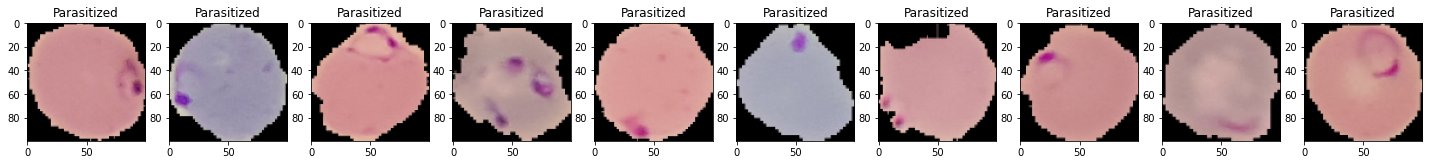

<Figure size 432x288 with 0 Axes>

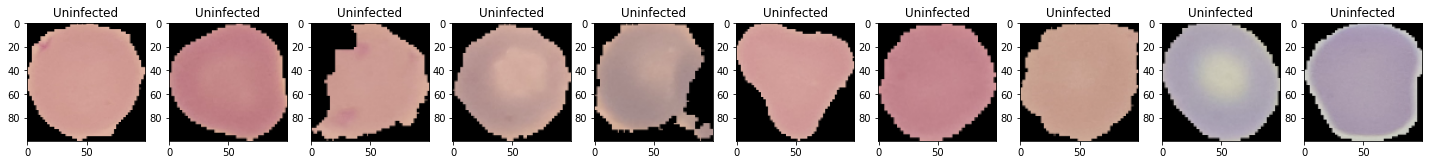

In [30]:
# Let see few images from each train category
for category in categories:
    display_images(path=os.path.join(BASE_PATH, "train", category), number_images=10)

<Figure size 432x288 with 0 Axes>

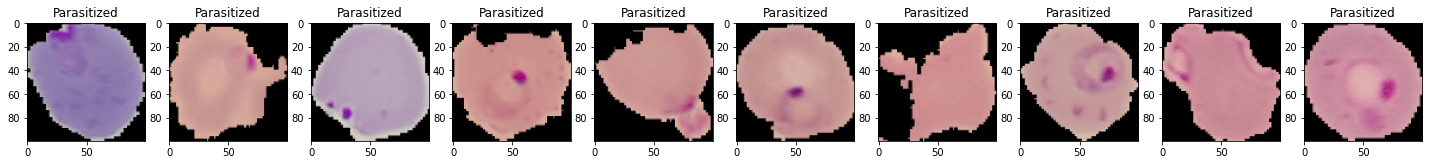

<Figure size 432x288 with 0 Axes>

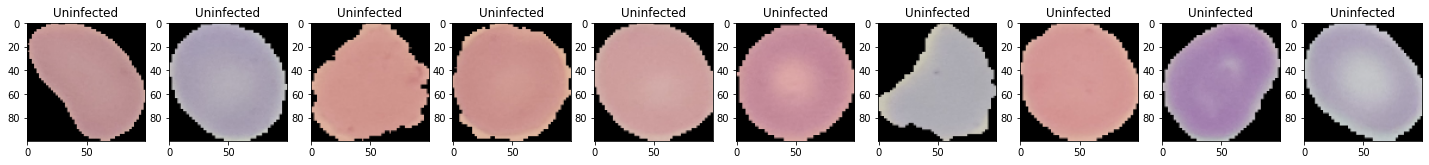

In [31]:
# Let see few images from each valid category
for category in categories:
    display_images(path=os.path.join(BASE_PATH, "valid", category), number_images=10)

In [32]:
batch_size = 150
datagen = image.ImageDataGenerator()
train_datagen = datagen.flow_from_directory(os.path.join(BASE_PATH, "train"), target_size=(110, 110), class_mode="categorical", shuffle=True, batch_size=batch_size)
valid_datagen = datagen.flow_from_directory(os.path.join(BASE_PATH, "valid"), target_size=(110, 110), class_mode="categorical", shuffle=True, batch_size=batch_size)

Found 20670 images belonging to 2 classes.
Found 6888 images belonging to 2 classes.


In [33]:
X_input = Input((110, 110, 3))

# Zero-Padding: pads the border of X_input with zeroes
X = layers.ZeroPadding2D((3, 3))(X_input)

# CONV -> BN -> RELU Block applied to X
X = layers.Conv2D(32, (7, 7), strides=(1, 1), name="conv0")(X)
X = layers.BatchNormalization(axis=3, name="bn0")(X)
X = layers.Activation("relu")(X)

# MORE CONVS
X = layers.MaxPooling2D((2, 2))(X)
#shortcut = X
X = layers.Conv2D(32, (3, 3), strides=(1, 1), padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation("relu")(X)
X = layers.Conv2D(32, (3, 3), strides=(1, 1), padding="same")(X)
X = layers.BatchNormalization()(X)
#X = layers.add([X, shortcut])
X = layers.Activation("relu")(X)

# MAXPOOL
X = layers.MaxPooling2D((2, 2), name="max_pool")(X)

# FLATTEN X (means convert it to a vector) + FULLYCONNECTED
X = layers.Flatten()(X)

# MORE DENSE
X = layers.Dense(128)(X)
X = layers.BatchNormalization()(X)
X = layers.Activation("relu")(X)
X = layers.Dropout(0.5)(X)

X_output = layers.Dense(2, activation="softmax", name="fc")(X)

# Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
model = Model(inputs = X_input, outputs = X_output, name="HappyModel")
model.compile(optimizers.Adam(lr=0.0001), "categorical_crossentropy", ["accuracy"])

In [34]:
callback = keras.callbacks.ModelCheckpoint(os.path.join(BASE_PATH, "weights", "best_malaria.h5"), monitor="val_accuracy", verbose=1, 
                                           save_weights_only=True, save_best_only=True, mode="max")

In [35]:
if os.path.isfile(os.path.join(BASE_PATH, "weights", "best_malaria.h5")):
    model.load_weights(os.path.join(BASE_PATH, "weights", "best_malaria.h5"))

In [36]:
history = model.fit_generator(train_datagen, epochs=50, validation_data=valid_datagen, callbacks=[callback])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
138/138 [==============================] - ETA: 0s - loss: 0.6575 - accuracy: 0.6875
Epoch 00001: val_accuracy improved from -inf to 0.66913, saving model to best_malaria.h5
138/138 [==============================] - 75s 543ms/step - loss: 0.6575 - accuracy: 0.6875 - val_loss: 0.7347 - val_accuracy: 0.6691
Epoch 2/50
138/138 [==============================] - ETA: 0s - loss: 0.3818 - accuracy: 0.8304
Epoch 00002: val_accuracy improved from 0.66913 to 0.80996, saving model to best_malaria.h5
138/138 [==============================] - 75s 540ms/step - loss: 0.3818 - accuracy: 0.8304 - val_loss: 0.4234 - val_accuracy: 0.8100
Epoch 3/50
138/138 [==============================] - ETA: 0s - loss: 0.2286 - accuracy: 0.9093
Epoch 00003: val_accuracy improved from 0.80996 to 0.85482, saving model to best_malaria.h5
138/138 [==============================] - 75s 543ms/step - loss: 0.2286 - accuracy: 0.9093 - v

Epoch 28/50
138/138 [==============================] - ETA: 0s - loss: 0.0095 - accuracy: 0.9984
Epoch 00028: val_accuracy did not improve from 0.93786
138/138 [==============================] - 58s 422ms/step - loss: 0.0095 - accuracy: 0.9984 - val_loss: 0.2664 - val_accuracy: 0.9300
Epoch 29/50
138/138 [==============================] - ETA: 0s - loss: 0.0089 - accuracy: 0.9988
Epoch 00029: val_accuracy did not improve from 0.93786
138/138 [==============================] - 58s 422ms/step - loss: 0.0089 - accuracy: 0.9988 - val_loss: 0.3302 - val_accuracy: 0.9239
Epoch 30/50
138/138 [==============================] - ETA: 0s - loss: 0.0094 - accuracy: 0.9981
Epoch 00030: val_accuracy did not improve from 0.93786
138/138 [==============================] - 54s 394ms/step - loss: 0.0094 - accuracy: 0.9981 - val_loss: 0.3571 - val_accuracy: 0.9168
Epoch 31/50
138/138 [==============================] - ETA: 0s - loss: 0.0082 - accuracy: 0.9982
Epoch 00031: val_accuracy did not improve fro

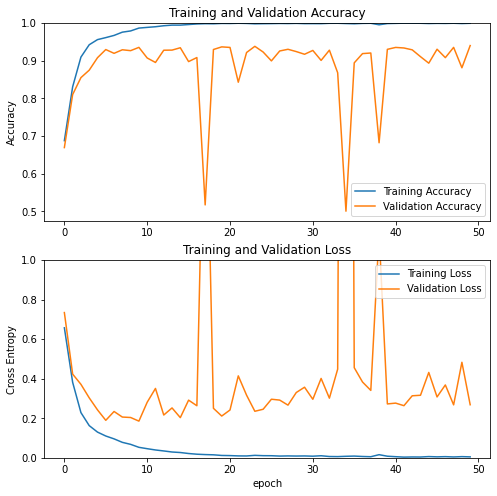

In [37]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.ylabel("Accuracy")
plt.ylim([min(plt.ylim()),1])
plt.title("Training and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.ylabel("Cross Entropy")
plt.ylim([0,1.0])
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()

In [47]:
from sklearn.metrics import classification_report, confusion_matrix

model.load_weights("../weights/best_malaria.h5")
Y_pred = model.predict_generator(valid_datagen)
y_pred = np.argmax(Y_pred, axis=1)
print("Confusion Matrix")
print(confusion_matrix(valid_datagen.classes, y_pred))

Instructions for updating:
Please use Model.predict, which supports generators.
Confusion Matrix
[[1712 1732]
 [1648 1796]]


In [49]:
version=1
tf.keras.models.save_model(model, f"../tf_serving/{version}/", overwrite=True, include_optimizer=True, save_format=None,
                        signatures=None, options=None)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../tf_serving/1/assets
